## Identifying Persons of Interest at Enron Using Emails and Financial Data
### By: Darren Liu

### Objective:
> The goal of this project is to identify persons of interest in one of the most infamous US corporate scandals in recent memory. The email corpus and financial details released to the public allowed the opportunity to use actual data to solve a real world problem. The use of supervised classification algorithms from machine learning will help a great deal in the identification of these persons. There will be discussion on the dataset, feature selection, models employed, and outcomes.

In [1]:
# initial setup
import warnings
warnings.filterwarnings("ignore")

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Data:
> The data made available for this project came in the form of 145 observations and 24 features. Some of the first things to change are:
> - Remove TOTAL as an observation, the aggregate sum of all observations
> - Remove THE TRAVEL AGENCY IN THE PARK as an observation, it does not seem like a plausible POI candidate
> - Remove LOCKHART EUGENE E as an observation, Eugene has no features with values
> - Remove email as a variable, it contains no releveant information

In [2]:
# remove TOTAL and emails
data_dict.pop('TOTAL', 0)
data_dict.pop('LOCKHART EUGENE E', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)
for p in data_dict.keys():
    del data_dict[p]['email_address']

In [3]:
# quick transform of 'NaN' into None for Pandas summary description
dat_dict_pd = [{k: data_dict[p][k] if data_dict[p][k] != 'NaN' else None for k in data_dict[p].keys()} for p in data_dict.keys()]
dat_pd = pd.DataFrame(dat_dict_pd)
# by POI summary
dat_pd.groupby('poi').describe()

bonus  deferral_payments  deferred_income  \
poi                                                               
False count       65.000000          33.000000        37.000000   
      mean    986824.923077      890346.212121   -445998.459459   
      std    1173879.759248     1341381.033477    762791.408207   
      min      70000.000000     -102500.000000  -3367011.000000   
      25%     400000.000000       85430.000000   -575000.000000   
      50%     700000.000000      260455.000000   -121284.000000   
      75%    1000000.000000      875307.000000    -36666.000000   
      max    8000000.000000     6426990.000000     -1042.000000   
True  count       16.000000           5.000000        11.000000   
      mean   2074999.937500      519894.200000  -1035313.454545   
      std    2047437.319350      912889.495638   1334971.876158   
      min     200000.000000       10259.000000  -3504386.000000   
      25%     775000.000000       27610.000000  -1860244.500000   
      50%    1275000.000000      202911.000000   -262500.000000   
      75%    2062500.000000      214678.000000   -122031.000000   
      max    7000000.000000     2144013.000000      -833.000000   

             director_fees  exercised_stock_options       expenses  \
poi                                                                  
False count      16.000000                89.000000      76.000000   
      mean    89822.875000           1947752.370787   52846.315789   
      std     41112.700735           2547067.767688   48036.089983   
      min      3285.000000              3285.000000     148.000000   
      25%     83674.500000            436515.000000   18254.000000   
      50%    106164.500000           1030329.000000   44601.000000   
      75%    112815.000000           2165172.000000   76764.750000   
      max    137864.000000          15364167.000000  228763.000000   
True  count       0.000000                12.000000      18.000000   
      mean             NaN          10463793.666667   59873.833333   
      std              NaN          12382588.130663   37524.658812   
      min              NaN            384728.000000   16514.000000   
      25%              NaN           1456581.000000   31323.250000   
      50%              NaN           3914557.000000   50448.500000   
      75%              NaN          19386043.750000   84125.000000   
      max              NaN          34348384.000000  127017.000000   

             from_messages  from_poi_to_this_person  from_this_person_to_poi  \
poi                                                                            
False count      72.000000                72.000000                72.000000   
      mean      668.763889                58.500000                36.277778   
      std      1978.997801                87.995198                85.139690   
      min        12.000000                 0.000000                 0.000000   
      25%        20.500000                10.000000                 0.000000   
      50%        41.000000                26.500000                 6.000000   
      75%       216.500000                61.750000                23.250000   
      max     14368.000000               528.000000               411.000000   
True  count      14.000000                14.000000                14.000000   
      mean      300.357143                97.785714                66.714286   
      std       805.844574                76.058862               158.289622   
      min        16.000000                13.000000                 4.000000   
      25%        33.000000                44.500000                12.500000   
      50%        44.500000                62.000000                15.500000   
      75%       101.500000               135.750000                28.750000   
      max      3069.000000               240.000000               609.000000   

               loan_advances  long_term_incentive            other  \
poi                                        

> This leaves 144 actual data points and 23 features. 18 of them have been identified as persons of interest (POI). A closer look quickly reveals several features with few or no values for either POI or non-POI. This includes director_fees, loan_advances, and restricted_stock_deferred.

### Feature Selection:
> The first step I took was create side-by-side boxplots of normalized features for POI's and non-POI's.

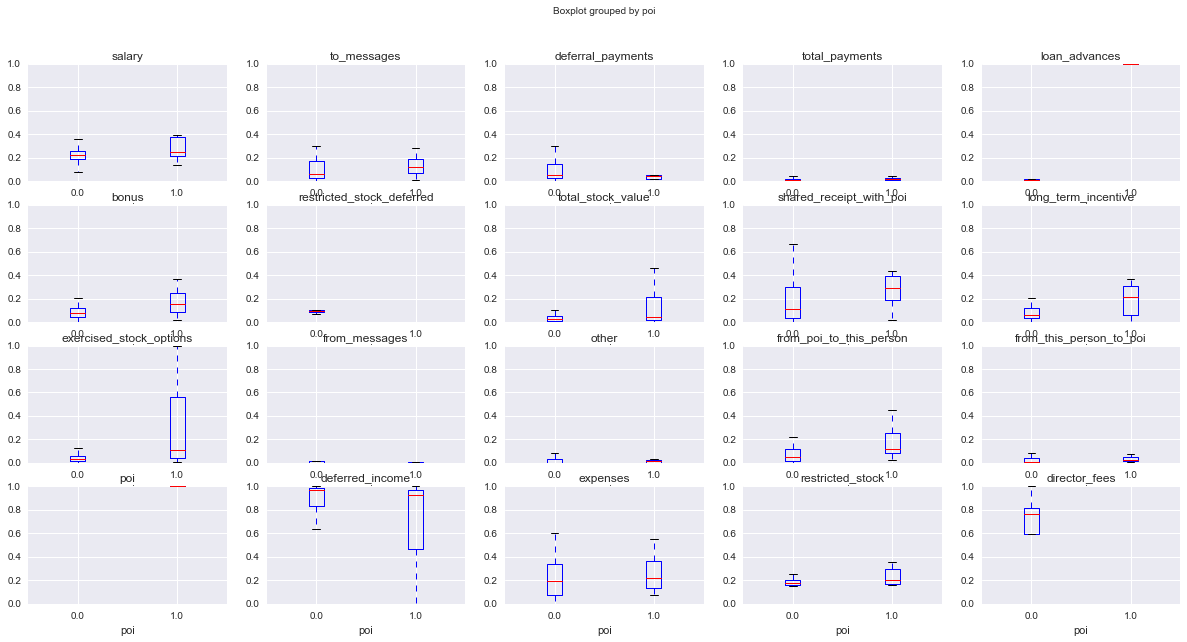

In [4]:
# normalize varibles for better view
vars_plt = dat_dict_pd[0].keys()

dat_plt = dat_pd
dat_plt -= dat_plt.min()
dat_plt /= dat_plt.max()
dat_plt.describe()

# boxplots
nrows = 4
ncols = 5

%matplotlib inline

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

for i in range(0, len(vars_plt)):
    nrow = int(i / ncols)
    ncol = i % ncols 
    dat_plt.boxplot(vars_plt[i], by='poi', ax=axes[nrow,ncol])


> Financials:
- Most features pointing to personal financial gains, such as salary, bonus, total stock value, long term incentives, exercised stock options, and restricted stocks are all noticeably higher for POIs
- Total payments had one exorbitant outlier that squashed the entire dataset. He was found to have been the outlier in all other financial gain categories as well by a long shot. He will be revealed shortly.

> Emails:
- POIs received more emails
- POIs shared more email receipts with other POIs
- POIs received more emails from other POIs
- There were several high volume emailers that squashed boxplots pertaining to email sending

#### New feature:
> I felt the need to add a feature that represents the ratio of emails sent to POIs compared to the volume of emails sent. The reasoning is that there are some non-POIs that send large volumes of emails, and as a result, send many emails to POIs. This behavior obscures POIs that don't send many emails regularly, but the ratio that is sent to POIs is high. This variable is called to_poi_ratio

#### Select features:
> SelectKBest from sklearn was the algorithm of choice in deciding what features to use. It scored the features as such:
- ('to_messages', 3.0),
- ('deferral_payments', 0.0),
- ('bonus', 31.0),
- ('total_stock_value', 11.0),
- ('expenses', 4.0),
- ('from_poi_to_this_person', 5.0),
- ('deferred_income_ratio', 0.0),
- ('from_this_person_to_poi', 0.0),
- ('exercised_stock_ratio', 0.0),
- ('deferred_income', 8.0),
- ('from_poi_ratio', 0.0),
- ('restricted_stock', 8.0),
- ('long_term_incentive', 8.0),
- ('salary', 16.0),
- ('total_payments', 9.0),
- ('loan_advances', 7.0),
- ('restricted_stock_deferred', 1.0),
- ('shared_receipt_with_poi', 11.0),
- ('exercised_stock_options', 10.0),
- ('from_messages', 0.0),
- ('other', 3.0),
- ('to_poi_ratio', 14.0),
- ('director_fees', 2.0)

> The selection cut-off was > 2. Which left me with 14 variables.

#### Normalization
> Algorithms responded differently to normalization. Naive-Bayes performed better with unnormalized features, whereas SVM performed better with normalized features. The reasoning here might be that normalization with the existence of outliers might squash non-outliers into data points of no difference, which hurts Naive-Bayes ability to differentiate amongst non-outliers. The same situation however, helps SVM in allowing its separation line to navigate properly through the feature dimensions without going over its allowed flexibility parameter.

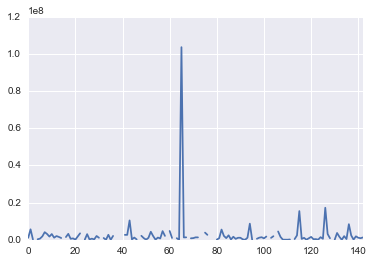

In [5]:
# one man had his hand deep deep in the cookie jar
dat_pd.total_payments.plot()

In [6]:
# oh Mr Lay
np.array(data_dict.keys())[np.array(dat_pd.total_payments == dat_pd.total_payments.max())]

array(['LAY KENNETH L'], 
      dtype='|S27')

### Algorithm Selection
Like SelectKBest did for feature selection, GridSearchCV was the algorithm of choice here. With the help of Pipeline, many combinations of sklearn tools such as MinMaxScaler, SelectKBest, PCA, were chained together with a given algorithm; GridSearchCV tested combinations of parameter for optimal cross validation results. The search ended on the use of Naive-Bayes and SVM, each with precision and recall above the required 0.3 threshold.
> Naive-Bayes:

>> SelectKBest(k=6) --> GaussianNB()

>> Precision : 0.41012

>> Recall : 0.35250

>> Normalization and PCA hurt performances significantly. Performance is best with a modest 6 variables out of the available 14.

> Support Vector Machine:

>> MinMaxScaler() --> SVC(C=1, gamma='auto', class_weight='balanced')

>> Precision : 0.30664

>> Recall : 0.672

>> PCA hurt performances significantly. Performance is best using normalized versions of all 14 available variables. C was tested on scales of [0.01, 0.1, 1, 10, 100], 1 was found to be optimal. class_weight = 'balanced' out-performed default setting of None.

#### Tuning
> Model tuning allows algorithms to find its most suitable form for the problem at hand. It was a process of trial-and-error made easy by GridSearchCV. It has the ability to find the optimal set of hyperparameters from the choices given by testing each combination with cross validation. The process was more rewarding than I anticipated, some algorithms like SVM went from unfeasible to great.

> With more experience, a good data scientist should have a better sense of what parameters and values to start the investigation with, as well as have the ability to anticipate or rationalize changes in performance post tuning. Hyperparameter optimization can take up a bit of time if many values for multiple parameters are attempted at the same time.

> My thoughts on normalization and PCA prior to this was that they can only help, not harm. But it was proven otherwise. PCA appeared to be best when used with regression type methods, such as logistic regression, where collinearity is an issue. The optimal number of variables also vary, SVM seems very comfortable with high data dimensionality. More rigorous feature selection were found to be more important with the other algorithms.

#### Validation and Metrics
> Validation is essentially the final exam, and if done properly, is an indicator of how effective a given algorithm should be when deployed. The proper validation process is cross validation, which requires randomly separating the dataset into two partitions: training and testing. Algorithms will only be trained on the training set. This setup allows out-of-sample predictions and lowers the chance of overfitting.

> Algorithm efficacy are tested by repeated cross validation attempts until 15000 total predictions have been made. Random training and testing sets are generated by StratifiedShuffleSplit from sklearn. This method is an enriched version of StratifiedKFold, adding the randomized shuffling of ShuffleSplit. The tester script provide similar metrics as those by classification_report from sklearn. The metrics focused on in this project are precision and recall.

> $$ Precision = \frac{True\,Positive}{True\,Positive+False\,Positive} $$

> $$ Recall = \frac{True\,Positive}{True\,Positive+False\,Negative} $$

> High precision in plain words is finding the target without being wrong. If all POIs were found but many non-POIs were also mislabelled, there is low precision.

> High recall on the other hand is finding the target without missing too many of them. If all persons targetted were indeed POI but many that was not labelled were also POI, there is low recall.

> In comparing the two algorithms, SVM exhibits stronger aggression as it captured more true positives at 1364 to NB's 681, but at the cost of 2965 false positives to NB's 934. Therefore, it had a strong performance in recall (less POIs were uncaptured) but weak performance in precision (many were falsely labelled).

#### Algorithm
> Having to choose between the two algorithms, I find it better to be more precise. There are only 144 candidates, if the investigator wanted to ensure that no fish escapes the net, it might be worth the time to scrutinize all candiates without the help of an algorithm. However, a more precise algorithm might help pinpoint the real bad doers and focus all firepower there. Therefore, the Naive-Bayes is the chosen algorithm.